In [ ]:
# EMA Strategy Backtest with KPIs (CAGR, Drawdown, Sharpe, Win Rate, Profit Factor)



### 📌 EMA Crossover Backtest Steps

* EMA20 > EMA50 → **BUY**
* EMA20 < EMA50 → **SELL**

**Backtest Logic**

1. Price data downloaded (`yfinance`)
2. EMA20 & EMA50 calculated
3. Crossover signal generated (1 = long, 0 = flat)
4. Position applied with one-day delay
5. Returns calculated:
   * Buy & Hold (passive investing)
   * Strategy return (signal-based investing)
6. Cumulative returns plotted

* `signal.shift(1)` → used to simulate taking the trade **the next day**

In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt

In [32]:
start_date = dt.datetime.today() -dt.timedelta(days=3600)
end_date = dt.datetime.today()
df = yf.download("AAPL",start=start_date,end=end_date)
df = df[["Close"]]

/var/folders/49/q5q_jjls7tq8knq4wvstm17m0000gn/T/ipykernel_6336/3331238133.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL",start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed


In [33]:
#indicators 
df["EMA20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["EMA50"] = df["Close"].ewm(span=50, adjust=False).mean()

In [34]:
#buy-sell signals
df["signal"] = np.where(df["EMA20"] > df["EMA50"], 1, 0)
df["position"] = df["signal"].shift(1)  # trade next day
#or df["position"] = (df["EMA20"] > df["EMA50"]).shift(1)

In [35]:
#buy-sell signals
df["signal"] = np.where(df["EMA20"] > df["EMA50"], 1, 0)
df["position"] = df["signal"].shift(1)  # trade next day
#or df["position"] = (df["EMA20"] > df["EMA50"]).shift(1)

#daily returns 
df["return"] = df["Close"].pct_change()
df["strategy_return"] = df["return"] * df["position"]
#cumulative returns 
df["strategy_cum"] = (1 + df["strategy_return"]).cumprod()
df["bh_cum"] = (1 + df["return"]).cumprod()  


In [39]:
#KPI'S

def CAGR(df):
    df = df.copy()
    df["return"] = df["Close"].pct_change()
    df["cum_return"] = (1 + df["return"]).cumprod()
    n = len(df) / 252
    return (df["cum_return"].iloc[-1]) ** (1/n) - 1

def max_drawdown(df):
    df = df.copy()
    df["return"] = df["Close"].pct_change()
    df["cum_return"] = (1 + df["return"]).cumprod()
    df["rolling_max"] = df["cum_return"].cummax()
    df["drawdown"] = (df["cum_return"] - df["rolling_max"]) / df["rolling_max"]
    return df["drawdown"].min()

def sharpe_ratio(df, risk_free_rate=0.03):
    df = df.copy()
    # daily return
    df["daily_ret"] = df["Close"].pct_change()
    # average daily return
    avg_daily_return = df["daily_ret"].mean()
    daily_volatility = df["daily_ret"].std()
    sharpe = ((avg_daily_return - risk_free_rate/252) / daily_volatility) * np.sqrt(252)
    return sharpe

def win_rate(trade_returns):
    trade_returns = np.array(trade_returns)
    wins = trade_returns[trade_returns > 0]
    return len(wins) / len(trade_returns) * 100

def profit_factor(trade_returns):
    trade_returns = np.array(trade_returns)
    gross_profit = trade_returns[trade_returns > 0].sum()
    gross_loss = abs(trade_returns[trade_returns < 0].sum())
    if gross_loss == 0:
        return np.inf 
    return gross_profit / gross_loss


In [42]:
def CAGR(df):
    df = df.copy()
    df["return"] = df["Close"].pct_change()
    df["cum_return"] = (1 + df["return"]).cumprod()
    n = len(df) / 252
    return (df["cum_return"].iloc[-1]) ** (1/n) - 1

def max_drawdown(df):
    df = df.copy()
    df["return"] = df["Close"].pct_change()
    df["cum_return"] = (1 + df["return"]).cumprod()
    df["rolling_max"] = df["cum_return"].cummax()
    df["drawdown"] = (df["cum_return"] - df["rolling_max"]) / df["rolling_max"]
    return df["drawdown"].min()

def sharpe_ratio(df, rf=0.03):
    daily_ret = df["strategy_return"]
    return (daily_ret.mean() - rf/252) / daily_ret.std() * np.sqrt(252)

def win_rate(returns):
    returns = returns.dropna()
    trades = returns[returns != 0]
    wins = trades[trades > 0]
    return len(wins) / len(trades) * 100

def profit_factor(returns):
    returns = returns.dropna()
    gains = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    return gains / losses if losses != 0 else np.inf


In [43]:
cagr = CAGR(df)
dd = max_drawdown(df)
sharpe = sharpe_ratio(df)
wr = win_rate(df["strategy_return"])
pf = profit_factor(df["strategy_return"])


CAGR:           nan
Max Drawdown:   nan
Sharpe Ratio:   0.7115
Win Rate:       5276.00%
Profit Factor:  1.20


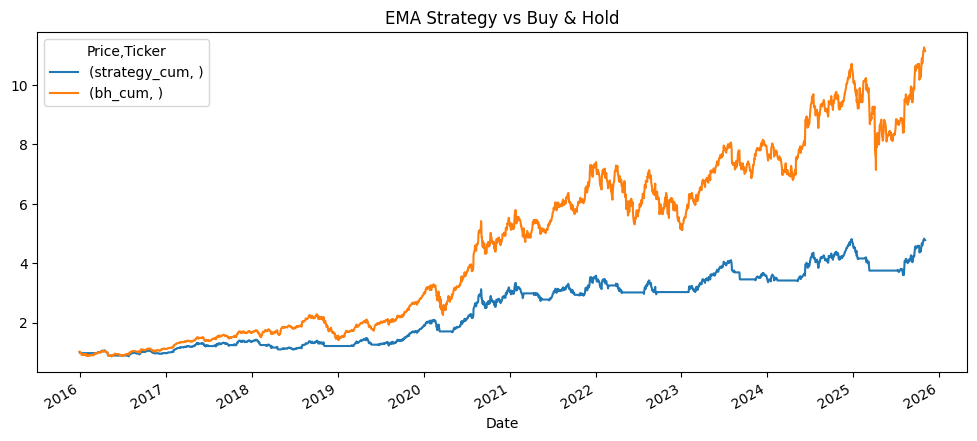

In [44]:
print(f"CAGR:           {cagr:.4f}")
print(f"Max Drawdown:   {dd:.4f}")
print(f"Sharpe Ratio:   {sharpe:.4f}")
print(f"Win Rate:       {wr:.2%}")
print(f"Profit Factor:  {pf:.2f}")

df[["strategy_cum", "bh_cum"]].plot(figsize=(12,5), title="EMA Strategy vs Buy & Hold");